<a href="https://colab.research.google.com/github/dipakp2726/Recipe-Master/blob/devlope/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libs


In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.4.0


171450368/171446536 [==============================] - 1s 0us/step


# setting path to dataset and parameters

In [7]:
data_dir ='/content/drive/MyDrive/Recipe Master/dataset/dataset' 
data_dir = pathlib.Path(data_dir)

In [8]:
batch_size = 32
img_height = 224
img_width = 224
IMG_SIZE = (img_height,img_width)

# spliting validation,test and train data

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 2400 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [11]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

# printing class names and random images from dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Handvo', 'Khaman', 'Khandvi', 'Muthiya', 'Thepla', 'Undhiyu']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# datapreprocessing

In [12]:
# normalizing img weights

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [35]:
# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
   
  ]
)

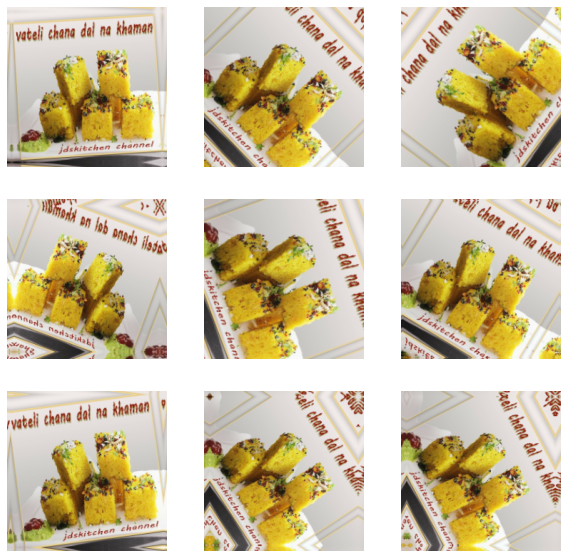

In [39]:
# augmentation preview
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# model creation

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, 
                                                    pooling='avg', classes=1000)

In [42]:
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
base_model.summary()

In [25]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')

In [43]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = rescale(x)
x = data_augmentation(inputs)
x = base_model(x, training=False)

x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [44]:
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 42,670,470
Trainable params: 12,294
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:


loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [55]:
checkpoint_path = "/content/checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## traing model

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
initial_epochs = 50
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                     callbacks=[cp_callback])

Epoch 1/30
75/75 [==============================] - 43s 528ms/step - loss: 1.4572 - accuracy: 0.5571 - val_loss: 1.0578 - val_accuracy: 0.6845
Epoch 2/30
75/75 [==============================] - 17s 230ms/step - loss: 1.0449 - accuracy: 0.6571 - val_loss: 0.8214 - val_accuracy: 0.7520
Epoch 3/30
75/75 [==============================] - 17s 230ms/step - loss: 0.8361 - accuracy: 0.7163 - val_loss: 0.6845 - val_accuracy: 0.7857
Epoch 4/30
75/75 [==============================] - 17s 225ms/step - loss: 0.7137 - accuracy: 0.7558 - val_loss: 0.6459 - val_accuracy: 0.8036
Epoch 5/30
75/75 [==============================] - 17s 223ms/step - loss: 0.6426 - accuracy: 0.7804 - val_loss: 0.5708 - val_accuracy: 0.8294
Epoch 6/30
75/75 [==============================] - 17s 226ms/step - loss: 0.5719 - accuracy: 0.8075 - val_loss: 0.5630 - val_accuracy: 0.8254
Epoch 7/30
75/75 [==============================] - 17s 228ms/step - loss: 0.5166 - accuracy: 0.8158 - val_loss: 0.5455 - val_accuracy: 0.8214

## plotting accuracy

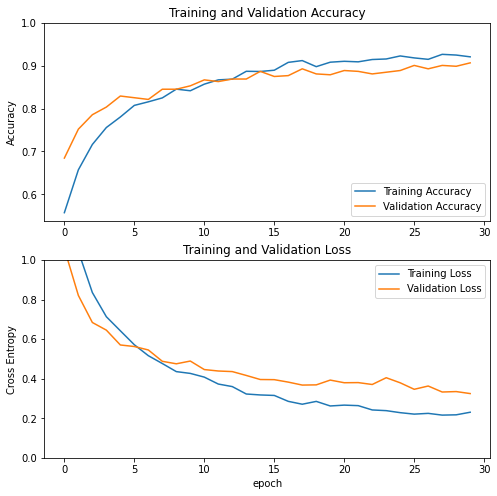

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:


loss0, accuracy0 = model.evaluate(test_ds)

3/3 [==============================] - 4s 297ms/step - loss: 0.3130 - accuracy: 0.9167


In [52]:
print("test loss: {:.2f}".format(loss0))
print("test accuracy: {:.2f}".format(accuracy0))

initial loss: 0.31
initial accuracy: 0.92
